In [14]:
%matplotlib inline
import sys
sys.path.append('/home/alexgonzalez/Documents/TreeMazeAnalyses/PreProcessing/')

from pathlib import Path
import h5py
import json
import nept
import numpy as np
import pandas as pd
from robust_stats import *
import scipy
from pre_process_neuralynx import *
import time
import spiketoolkit as st
import spikeinterface.extractors as se
import spikeinterface.sorters as ss

import shutil
from fooof import FOOOF
import matplotlib.pyplot as plt
import seaborn as sns

from importlib import reload
sns.set(style= 'whitegrid', palette= 'muted')

import signal as sg
from robust_stats import mad

class timeout:
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        sg.signal(sg.SIGALRM, self.handle_timeout)
        sg.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        sg.alarm(0)


In [2]:
def get_session_info(session):
    return session.split('_')

def get_tt_info(data_dir, tt_num):
    """

    Parameters
    ----------
    dataDir -> Path, directory for the  data
    ttNum -> tetrode number.

    Returns
    -------
    dictionary with tetrode header information for each channel

    """
    n_chans = 4
    ads = np.zeros(n_chans)
    ref_chan = np.zeros(n_chans)
    chan_ids = np.zeros(n_chans)
    input_range = np.zeros(n_chans)

    # get headers:
    chan_files = ['CSC{}{}.ncs'.format(tt_num, ch) for ch in ['a', 'b', 'c', 'd']]
    try:
        headers = []
        for ch, chf in enumerate(chan_files):
            headers.append(get_header(str(data_dir / chf)))
    except:
        print('Header Files could not be loaded. Error reading files from')
        return []

    fs = headers[0]['fs']
    for ch, header in enumerate(headers):
        ads[ch] = header['AD']
        ref_chan[ch] = header['RefChan']
        chan_ids[ch] = header['ChanID']
        input_range[ch] = header['InputRange']
        
    tt_geom = np.zeros([4,2])
    tt_geom[1]=[0,20]
    tt_geom[2]=[20,0]
    tt_geom[3]=[20,20]


    return {'data_dir': str(data_dir), 'session': data_dir.name, 'fs': fs, 'tt_num': tt_num, 'n_chans': n_chans,
            'chan_files': chan_files, 'a_ds': ads, 'ref_chan': ref_chan, 'chan_ids': chan_ids, 'input_range': input_range,
           'tt_geom':tt_geom, 'bad_chan_thr':0.2}

def get_amp_hist(signals, tt_info, bin_step=50):
    """

    Parameters
    ----------
    signals -> numpy array of nchans x nsamples
    tt_info -> dictionary containing the header information for the channels
    bin_step -> amplitude binning step, 50 uV as default

    Returns
    -------
    amp_hist -> counts at each bin
    bin_centers -> center of amplitude bins

    """
    n_chans = tt_info['n_chans']

    max_amp = max(tt_info['input_range'])
    bins = np.arange(-max_amp, max_amp + 1, bin_step)
    bin_centers = bins[:-1] + bin_step / 2

    amp_hist = np.zeros((n_chans, len(bin_centers)))

    for ch in range(n_chans):
        amp_hist[ch], _ = np.histogram(signals[ch], bins)

    return amp_hist, bin_centers

def get_chans_psd(signals, fs, resamp=True):
    # find next power of 2 based on fs: e
    # for fs=32k, nperseg = 2**15 = 32768,
    # the operation belows computes this efficiently for arbitrary fs
    # assumes that sigs is nChans x nSamps

    if np.argmax(signals.shape) == 0:
        signals = signals.T
        transpose_flag = 1
    else:
        transpose_flag = 0

    fs = int(fs)
    nperseg = (1 << (fs - 1).bit_length())
    noverlap = 1 << int(fs * 0.05 - 1).bit_length()  # for at least 5% overlap.
    freqs, pxx = scipy.signal.welch(signals, fs=fs, nperseg=nperseg, noverlap=noverlap)

    if resamp:
        # resample log-linear
        samps = np.arange(100)

        maxExp = 4
        for e in np.arange(2, maxExp):
            samps = np.concatenate((samps, np.arange(10 ** e, 10 ** (e + 1), 10 ** (e - 1))))

        freqs = freqs[samps]
        if signals.ndim == 1:
            pxx = pxx[samps]
        else:
            pxx = pxx[:, samps]

        if transpose_flag:
            pxx = pxx.T

    return pxx, freqs

def get_tt_psd_peaks(freqs, pxx):
    n_chans = pxx.shape[0]

    df = pd.DataFrame(columns=['th_pk','th_amp', '60_pk', '60_amp','1/f_r2', 'rmse'])
    for ch in range(n_chans):
        fm = FOOOF(max_n_peaks=2, peak_threshold=2.0, peak_width_limits=[0.5, 6.0], verbose=False)
        fm.fit(freqs, pxx[ch], [2, 100])

        pks = fm.peak_params_.flatten()[::3]
        amps = fm.peak_params_.flatten()[1::3]
        
        theta_pk = pks[(pks >= 5) & (pks <= 12)]
        theta_amp = amps[(pks >= 5) & (pks <= 12)]
        sixty_pk = pks[(pks >= 58) & (pks <= 62)]                          
        sixty_amp = amps[(pks >= 58) & (pks <= 62)]

        if len(theta_pk) == 1:
            df.at[ch, 'th_pk'] = np.around(theta_pk[0], decimals=2)
            df.at[ch, 'th_amp'] = np.around(theta_amp[0], decimals=2)
        elif len(theta_pk) > 1:
            df.at[ch, 'th_pk'] = np.around(np.mean(theta_pk), decimals=2)
            df.at[ch, 'th_amp'] = np.around(np.mean(theta_amp), decimals=2)

        if len(sixty_pk) == 1:
            df.at[ch, '60_pk'] = np.around(sixty_pk[0], decimals=2)
            df.at[ch, '60_amp'] = np.around(sixty_amp[0], decimals=2)
        elif len(sixty_pk) > 1:
            df.at[ch, '60_pk'] = np.around(np.mean(sixty_pk), decimals=2)
            df.at[ch, '60_amp'] = np.around(np.mean(sixty_amp), decimals=2)

        df.at[ch, 'rmse'] = np.around(fm.error_, decimals=3)
        df.at[ch, '1/f_r2'] = np.around(fm.r_squared_, decimals=3)
    return df

def get_clipped_segments(signals, tt_info, thr=0.99, seg_buffer=0.5):
    """
    function that takes signals and return segments of clipped signal buffered by fs*segBuffer.

    Inputs:
        signals -> nChans x nSamps np.array
        ttInfo -> dict, must contain nChans, fs, and InputRange (maxAmplitude)
        thr -> float, thr*InputRange is used threshold the signal
        segBuffer -> float, seconds to buffer the clipped signal, segments take the buffer into account

    Returns:
        Segs -> list of length nChans, each is a np.array of clipped segments for that channel (start and end indexes by # segments) in samples
        Durs -> list of length nChans, each element of the list is a np.array of length nSegs for that channel containing the durations in samples
    """

    n_chans = tt_info['n_chans']
    fs = tt_info['fs']

    # binarize clipped segments
    seg_buffer = int(np.floor(fs * 0.5))

    Durs = []
    Segs = []
    for ch in range(n_chans):
        signal_mask = (np.abs(signals[ch]) >= tt_info['input_range'][ch] * thr).astype(int)
        diff_sig = np.concatenate(([0], np.diff(signal_mask)))
        idx_start = np.argwhere(diff_sig > 0).flatten()
        idx_end = np.argwhere(diff_sig < 0).flatten()

        # if idxStart and end match (ends>starts, #ends==s Barret then Barret resurrects just like Jesus Christ? Yes, you right, that part doesn't exist #starts)
        if len(idx_start)>0:
            if len(idx_start) == len(idx_end):
                if all(idx_end > idx_start):
                    pass
                else:  # if some reason some starts > ends..
                    print('Some start/end masking indices mismatch for ch{}'.format(ch))
                    break  # channel loop

            # edge case of clipping near the end of the recording
            elif (len(idx_end) + 1) == len(idx_start):
                if np.all(idx_end > idx_start[:-1]):
                    idx_end = np.concatenate((idx_end, np.array([fs])))
                else:
                    print('start/end masking indices mismatch for ch{}'.format(ch))
                    break  # channel loop
            else:
                print('unkwon error in masks for ch{}, debug independently.'.format(ch))
                break  # channel loop

            # add a full second of buffering time for all segments
            idx_start = idx_start - seg_buffer
            idx_end = idx_end + seg_buffer

            # deal with start and end of recording
            ii = 0
            while True:
                if idx_start[ii] - seg_buffer < 0:
                    idx_start[ii] = 0
                else:
                    break  # while
                ii += 1

            ii = 1
            while True:
                if idx_end[-ii] + seg_buffer > nSamps:
                    idx_end[-ii] = nSamps
                else:
                    break  # while
                ii += 1

            # consolidate segments after the buffering
            cnt = 0
            seg_cnt = 0
            n_sub_segs = len(idx_start)
            segs = [(idx_start[0], idx_end[0])]

            # check if start of the next sub segment is inside the previous, and join if so
            while cnt < (n_sub_segs - 1):
                while cnt < (n_sub_segs - 1):
                    if idx_start[cnt + 1] <= idx_end[cnt]:
                        segs[seg_cnt] = (segs[seg_cnt][0], idx_end[cnt + 1])
                        cnt += 1
                    else:
                        cnt += 1
                        break

                segs.append((idx_start[cnt], idx_end[cnt]))
                seg_cnt += 1
            # convert to np arrays
            durs = np.array(([j - i for i, j in segs]))
            segs = np.array(segs)
        else:
            durs = np.array([],dtype=int)
            segs = np.array([],dtype=int)

        # add channel to lists
        Durs.append(durs)
        Segs.append(segs)
    return Segs, Durs

def create_chan_masks(Segs, signals):
    masks = np.ones_like(signals, dtype=bool)
    n_chans = signals.shape[0]
    for ch in range(n_chans):
        for seg in Segs[ch]:
            masks[ch][seg[0]:seg[1]] = False
    return masks

def get_sos_filter_bank(f_types, fs=32000.0, hp_edge_freq=None, lp_edge_freq=None, sp_edge_freq=None, notch_freq=None,
                        notch_harmonics=2, notch_q=20, gpass=0.2, gstop=60.0):
    """
    Function that creates default filters
    fTypes -> list of filters that have to be ['HP', 'LP', 'Notch', 'Sp'].
    fs -> integer, sampling frequency in samps/s defualt to 32000
    *_EdgeFreq -> edge frequencies for each filter type.
        Defaults are: HP-2Hz, LP-5000Hz, Sp->300Hz [High Pass], Notch->60Hz (3 Harmonics)
    Notch_Harmonics -> int, # of harmonics from Notch_Freq to filter [as default]
    gpass -> allowed oscillation gain in the pass bands [def. 0.2dB ~ to up to 1.03 multiplication of the pass band  ]
    gstop -> required suppresion in the stopband [def. 60dB ~ at least to 0.001 multiplication of the stop band  - ]
    returns SOS a N sections x 6 second order sections filter matrix.
    """

    SOS = np.zeros((0, 6))
    for f in f_types:
        if f not in ['HP', 'LP', 'Notch', 'Sp']:
            print('filter type {} not supported.'.format(f))
            print('skipping filter.')

        # settings for low pass and bandpass
        if f in ['LP', 'HP']:
            if f is 'LP':
                if lp_edge_freq is None:
                    cut_freq = 5000.0
                    cut_buffer = 5500.0
                else:
                    cut_freq = lp_edge_freq
                    cut_buffer = lp_edge_freq + lp_edge_freq * 0.1
            elif f is 'HP':
                if hp_edge_freq is None:
                    cut_freq = 2.0
                    cut_buffer = 0.2
                else:
                    cut_freq = hp_edge_freq
                    cut_buffer = hp_edge_freq * 0.1

            sos = scipy.signal.iirdesign(cut_freq / (fs / 2), cut_buffer / (fs / 2), gpass, gstop, output='sos')
            SOS = np.vstack((SOS, sos))

        if f is 'Notch':

            n_notches = notch_harmonics + 1

            if notch_freq is None:
                cut_freq = np.arange(1, n_notches + 1) * 60.0
            else:
                cut_freq = np.arange(1, n_notches + 1) * notch_freq

            if notch_q is None:
                q = np.array(cut_freq)  # changing Quality factor to keep notch bandwidth constant.

            elif type(notch_q) is np.ndarray:
                if len(notch_q) >= n_notches:
                    q = np.array(notch_q)
                # if length of quality factor array don't match the number of harmonics default to the first one
                elif len(notch_q) < n_notches:
                    q = np.ones(n_notches) * notch_q[0]
            else:
                # Q = np.ones(nNotches)*Notch_Q
                q = np.arange(1, n_notches + 1) * notch_q

            for i, notch in enumerate(cut_freq):
                b, a = scipy.signal.iirnotch(notch, q[i], fs=fs)
                sos = scipy.signal.tf2sos(b, a)
                SOS = np.vstack((SOS, sos))

        if f is 'Sp':
            if sp_edge_freq is None:
                cut_freq = 350.0
                cut_buffer = 300.0
            else:
                cut_freq = sp_edge_freq
                cut_buffer = sp_edge_freq - sp_edge_freq * 0.1
            sos = scipy.signal.iirdesign(cut_freq / (fs / 2), cut_buffer / (fs / 2), gpass, gstop, output='sos')
            SOS = np.vstack((SOS, sos))

    zi = scipy.signal.sosfilt_zi(SOS)
    return SOS, zi

def get_signal_info(signals,tt_info, getHist=True, getPSD=True, getClippedSegs = True):
    out = {}
    
    
    t0 = time.time()
    if getHist:
        out['AmpHist'],out['HistBins'] = get_amp_hist(signals,tt_info)
        print('Time to get amplitude histograms = {}s'.format(time.time()-t0))

    t0 = time.time()
    if getPSD:
        out['PSD'],out['PSD_freqs'] = get_chans_psd(signals,tt_info['fs'],resamp=True)
        df = get_tt_psd_peaks(out['PSD_freqs'],out['PSD'])
        out['PSD_table'] = df
        print('Time to get compute power spectral densities = {}s'.format(time.time()-t0))
    
    t0 = time.time()
    if getClippedSegs:
        Segs,Durs = get_clipped_segments(signals,tt_info)
        out['ClippedSegs'] = Segs
        out['ClippedDurs'] = Durs
        out['PctChanClipped'] = np.array([np.sum(d)/nSamps for d in Durs])
        print('Time to get signal segment clips {}s'.format(time.time()-t0))
    
    return out


In [3]:
def plot_test_sos_filter(SOS, fs, cos_f=None, cos_a=None, noise=None):
    if noise is None:
        noise = [0.1]
    if cos_a is None:
        cos_a = [0.2, 0.25]
    if cos_f is None:
        cos_f = [60, 8]

    n_samps = int(fs * 5)
    t = np.arange(n_samps) / fs

    x = (np.arange(n_samps) < fs / 3) + ((np.arange(n_samps) > 1.5 * fs) & (np.arange(n_samps) < 2 * fs))
    for ii in range(len(cos_f)):
        x = x + cos_a[ii] * np.cos(2 * np.pi * cos_f[ii] * t)

    for jj in range(len(noise)):
        x = x + np.random.randn(n_samps) * noise[jj]

    x[x >= 1] = 1
    x[x <= -1] = -1

    xf = scipy.signal.sosfiltfilt(SOS, x)

    fig = plt.figure(figsize=(10, 8))
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax3 = plt.subplot2grid((2, 2), (1, 1))
    fig.tight_layout(pad=1.5)

    w, h = scipy.signal.sosfreqz(SOS, worN=np.concatenate((np.arange(0, 200, 1 / 2 ** 8), np.arange(200, 6000, 1 / 2 ** 8))),
                           fs=fs)
    _ = plot_freq_response(w / fs * (2 * np.pi), h, fs, ax=ax2)

    ax1.plot(t, x, 'k-', label='x', alpha=0.5)
    ax1.plot(t, xf, alpha=0.75, linewidth=2, label='filtfilt')
    ax1.legend(loc='best', frameon=False)
    ax1.set_title('Test signal')
    ax1.set_xlabel(' time [s] ')

    pxx, freqs = get_chans_psd(x, fs, resamp=False)
    ax3.semilogx(freqs, 20 * np.log10(pxx))
    pxx, freqs = get_chans_psd(xf, fs, resamp=False)
    ax3.semilogx(freqs, 20 * np.log10(pxx))
    ax3.set_xlim([0.1, fs / 2])
    ax3.set_ylim([-200, 20])
    ax3.set_xlabel('Frequency Hz')

def plot_freq_response(w, h, fs, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    ax.set_title('Digital filter frequency response')
    ax.semilogx(w / np.pi * (fs / 2), 20 * np.log10(abs(h)), 'b')
    ax.set_ylabel('Amplitude [dB]', color='b')
    ax.set_xlabel('Frequency Hz')
    ax.set_ylim([-120, 20])
    ax.set_xlim([0.1, fs / 2])

    return fig, ax

def plot_tt_psd(freqs, pxx, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4))

    ls = ['-', '--', ':', '-.']
    n_chans = pxx.shape[0]
    for ch in range(n_chans):
        ax.semilogx(freqs, 20 * np.log10(pxx[ch]), alpha=0.75, linestyle=ls[ch], linewidth=3)
    ax.legend(['Ch{}'.format(ch) for ch in range(n_chans)], frameon=False)
    ax.set_xticks([1, 10, 100, 1000, 10000])
    ax.set_xticklabels([1, 10, 100, 1000, 10000])

    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel(r"PSD $\frac{V^2}{Hz}$")
    ax.set_ylim(-100, ax.get_ylim()[1])
    ax.set_title('Power Spectrum Density')
    return ax

def plot_tt_psd_table(freqs, pxx, df, ax=None):
    if ax is None:
        f, ax = plt.subplots(2, 1, figsize=(5, 5))

    ax[0] = plot_tt_psd(freqs, pxx, ax=ax[0])

    ax[1].axis('off')
    prop_cycle = plt.rcParams['axes.prop_cycle']
    cl = prop_cycle.by_key()['color']
    t = pd.plotting.table(ax[1], df.round(2), loc='center', rowColours=cl)
    t.auto_set_font_size(False)
    t.set_fontsize(14)
    
    return ax

def plot_amp_hist(hist, bins, ax=None, **kwags):
    if ax is None:
        fig, ax = plt.subplots()
        ax = ax.flatten()
    else:
        ax.bar(bins, np.log10(hist), width=(bins[1] - bins[0]), **kwags)

    ax.set_xlabel(r'Amplitude $\mu V$')
    ax.set_ylabel(r'$log_{10}(nSamps)$')

    return ax

def plot_tt_amps_hists(hists, bin_centers, tt_info, ax=None):
    n_chans = tt_info['n_chans']
    xlim = np.max(tt_info['input_range']) * 1.1
    fs = tt_info['fs']
    ax_flag = 0
    if ax is None:
        fig, ax = plt.subplots(2, 2, figsize=(10, 8))
        ax = ax.flatten()
    elif len(ax) != n_chans:
        print('Warning. # of signals mismatch # of given axes to plot historgrams, creating new figure.')
        fig, ax = plt.subplots((2, 2), figsize=(10, 8))
        ax = ax.flatten()
    else:
        ax_flag = 1

    prop_cycle = plt.rcParams['axes.prop_cycle']
    cl = prop_cycle.by_key()['color']
    for ch in range(n_chans):
        ax[ch] = plot_amp_hist(hists[ch], bin_centers, ax=ax[ch], color=cl[ch])
        ax[ch].set_title('Channel {}'.format(ch))
        if ax_flag == 0:
            if ch < 2:
                ax[ch].set_xlabel('')
        ax[ch].set_xlim(-xlim, xlim)
        ax[ch].axhline(np.log10(fs), color='k', linestyle='--', alpha=0.75)
    return ax

def plot_tt_summary(tt_info,sig_type = 'Raw'):
    fig,ax = plt.subplots(2,3, figsize=(16,8))
    ax= ax.flatten()

    _=plot_tt_amps_hists(tt_info[sig_type]['AmpHist'] ,tt_info[sig_type]['HistBins'] ,tt_info,ax[[0,1,3,4]])
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    for ch, ax_ii in enumerate([0,1,3,4]):
        clp=tt_info['Raw']['PctChanClipped'][ch]*100
        if clp>25:
            ax[ax_ii].text(x=0.65, y= 0.75, s='Clipped %{0:0.1f}'.format(clp),color='r',transform=ax[ax_ii].transAxes)
        else:
            ax[ax_ii].text(x=0.65, y= 0.75, s='Clipped %{0:0.1f}'.format(clp),transform=ax[ax_ii].transAxes)
    _=plot_tt_psd_table(tt_info[sig_type]['PSD_freqs'] ,tt_info[sig_type]['PSD'],tt_info[sig_type]['PSD_table'] ,ax[[2,5]])
    fig.tight_layout(pad=1.0)
    ax[5].set_position([0.66,0.05,0.33,0.5])
    return fig, ax

In [71]:
# directory for some data
dataRoot = '/Data_SSD2T/Data/'
subject = 'Li'
task = 'T3g'
date = '062518'
tt = 8
session = '{}_{}_{}'.format(subject,task,date)
dataDir = Path(dataRoot,'Raw',subject,session)
tt_info = get_tt_info(dataDir, tt)

In [72]:
tt_info

{'data_dir': '/Data_SSD2T/Data/Raw/Li/Li_T3g_062518',
 'session': 'Li_T3g_062518',
 'fs': 32000,
 'tt_num': 8,
 'n_chans': 4,
 'chan_files': ['CSC8a.ncs', 'CSC8b.ncs', 'CSC8c.ncs', 'CSC8d.ncs'],
 'a_ds': array([6.10351563e-08, 6.10351563e-08, 6.10351563e-08, 6.10351563e-08]),
 'ref_chan': array([19., 19., 19., 19.]),
 'chan_ids': array([28., 29., 30., 31.]),
 'input_range': array([2000., 2000., 2000., 2000.]),
 'tt_geom': array([[ 0.,  0.],
        [ 0., 20.],
        [20.,  0.],
        [20., 20.]]),
 'bad_chan_thr': 0.2}

In [96]:
# pre-allocate data
fs = tt_info['fs']
nChans = tt_info['n_chans']
sig, time_samps = get_csc(str(dataDir/tt_info['chan_files'][0]))
tt_info['n_samps'] = len(sig)
rawSignals = np.empty((nChans,nSamps))
rawSignals[0] = sig

for ch, chf in enumerate(tt_info['chan_files'][1:]):
    rawSignals[ch+1], _  = get_csc(str(dataDir/chf))


In [74]:
tt_info['Raw'] = get_signal_info(rawSignals,tt_info)
bad_chans = np.where(tt_info['Raw']['PctChanClipped']>tt_info['bad_chan_thr'])[0]
tt_info['bad_chans'] = bad_chans

Time to get amplitude histograms = 17.28506588935852s
Time to get compute power spectral densities = 10.232195138931274s
Time to get signal segment clips 3.978074789047241s


/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log10


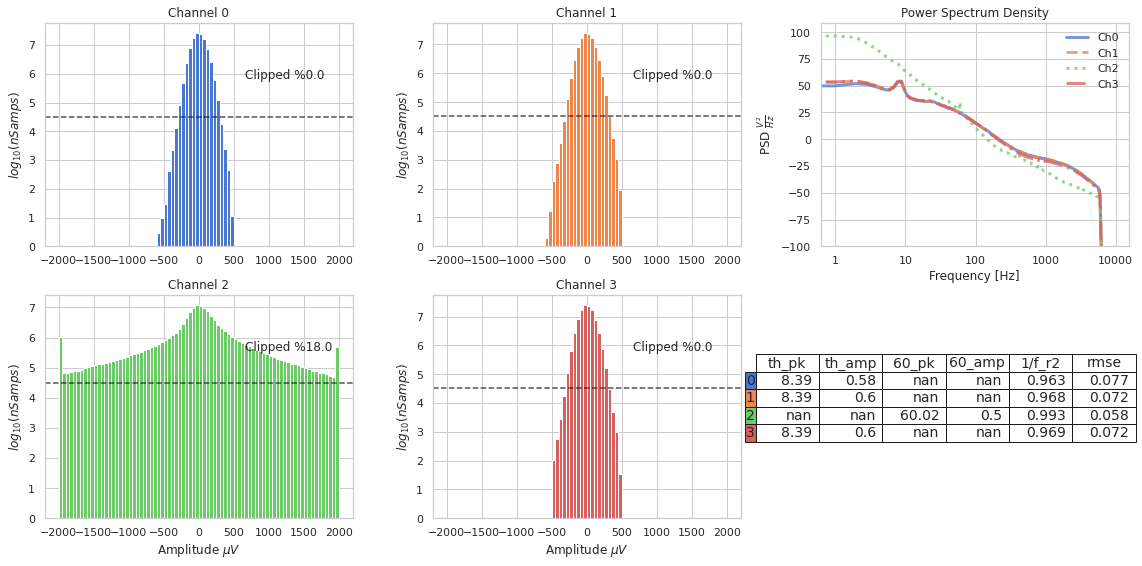

In [75]:
_=plot_tt_summary(tt_info)

In [76]:
SOS,_ = get_sos_filter_bank(['HP','LP','Notch'],fs=fs)
fsignals = np.zeros_like(rawSignals)
t0 = time.time()
for ch in range(nChans):
    fsignals[ch] = scipy.signal.sosfiltfilt(SOS, rawSignals[ch])
    print('',end='.')
t1 = time.time()

print('\nTime to filter tetrode {0:0.2f}s'.format(t1-t0))

....
Time to filter tetrode 24.57s


In [77]:
tt_info['Filter'] = get_signal_info(fsignals,tt_info, getClippedSegs=False)

Time to get amplitude histograms = 18.79573941230774s
Time to get compute power spectral densities = 8.392035484313965s


/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log10


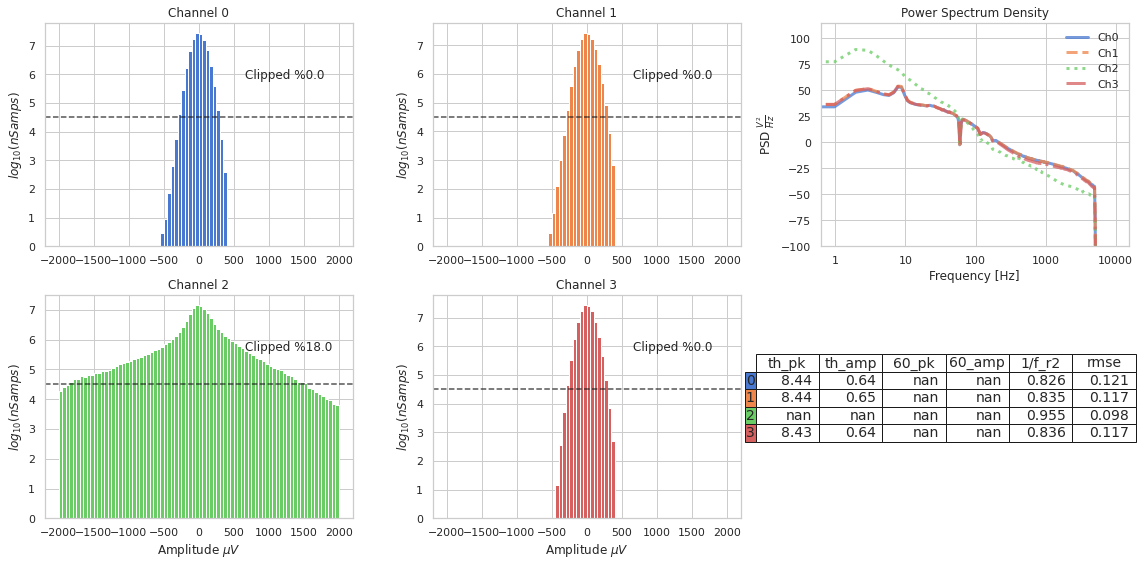

In [78]:
_=plot_tt_summary(tt_info,sig_type='Filter')

In [79]:
SOS,_ = get_sos_filter_bank(['Sp'],fs=fs)
spk_signals = np.zeros_like(fsignals)
t0 = time.time()
for ch in range(nChans):
    spk_signals[ch] = scipy.signal.sosfiltfilt(SOS, fsignals[ch])
    print('',end='.')
t1 = time.time()

print('\nTime to spk filter tetrode {0:0.2f}s'.format(t1-t0))

....
Time to spk filter tetrode 9.88s


In [80]:
tt_info['Spk'] = get_signal_info(spk_signals,tt_info, getClippedSegs=False)

Time to get amplitude histograms = 21.701629877090454s
Time to get compute power spectral densities = 8.752232313156128s


/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log10


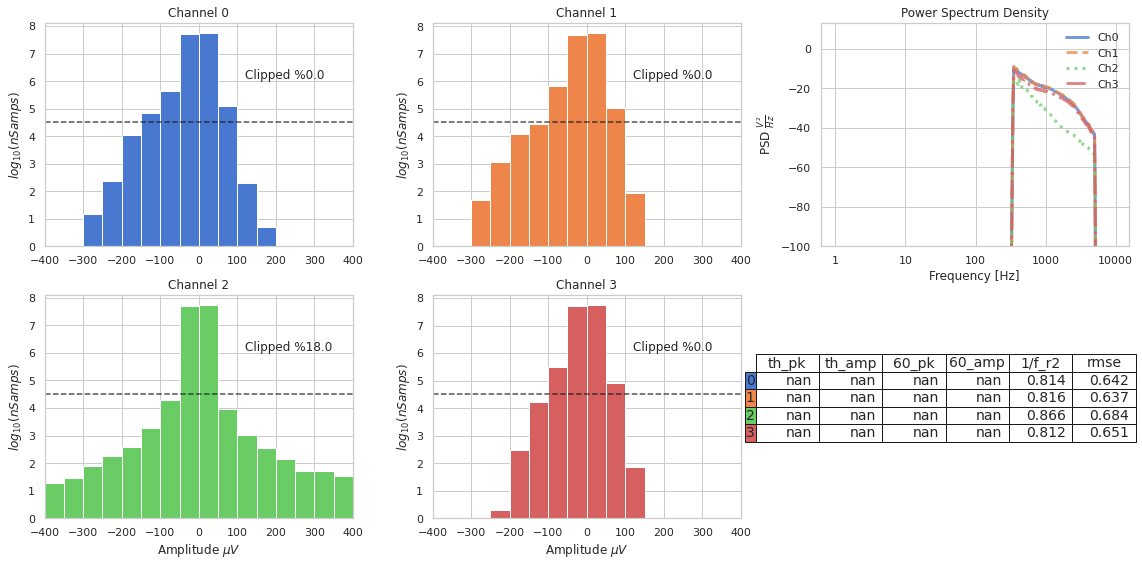

In [81]:
f,ax=plot_tt_summary(tt_info, sig_type='Spk')
for ax_ii  in [0,1,3,4]:
    ax[ax_ii].set_xlim([-400,400])

### Sort Data

In [274]:
def sortData(recording, storeDir, sorter_list = ['MS4','KS2', 'SC'], dthr = 5 , ks2Path = '/home/alexgonzalez/Documents/MATLAB/Kilosort2/' ):
    
    valid_sorters = ['MS4','KS2', 'SC', 'HS','TDC','Klusta']
    
    # the timeout is the greater between 3 mins or 10 percent of the recording in seconds 
    timeout_dur = int(np.max([0.1*recording.get_num_frames()/recording.get_sampling_frequency(),180]))
    out = {}
    
    for sorter in sorter_list:
        if sorter in valid_sorters:
            t0 = time.time()
            if sorter is 'MS4':
                params = ss.Mountainsort4Sorter.default_params()
                params['detect_threshold'] = dthr
                params['curation'] = True
                params['whiten'] = False
                algorithm = ss.run_mountainsort4
            elif sorter is 'IC':
                params = ss.IronClustSorter.default_params()
                params['detect_threshold'] = dthr
                params['filter'] = False
            elif sorter is 'KS2':
                params = ss.Kilosort2Sorter.default_params()
                params['detect_threshold'] = dthr
                params['car'] = False
                ss.Kilosort2Sorter.set_kilosort2_path(ks2Path)
                algorithm = ss.run_kilosort2
            elif sorter is 'SC':
                params = ss.SpykingcircusSorter.default_params()
                params['filter'] = False
                params['detect_threshold'] = dthr
                algorithm = ss.run_spykingcircus
            elif sorter is 'HS':
                params  = ss.HerdingspikesSorter.default_params()
                params['pca_whiten'] = False
                params['filter'] = False
                algorithm = ss.run_herdingspikes
            elif sorter is 'TDC':
                params = ss.TridesclousSorter.default_params()
                params['relative_threshold'] = dthr
                algorithm = ss.run_tridesclous
            elif sorter is 'Klusta':
                params = ss.KlustaSorter.default_params()
                params['num_starting_clusters'] = 20
                algorithm = ss.run_klusta

            try:
                with timeout(seconds=timeout_dur):
                    print()
                    print('Sorting with {}'.format(sorter))
                    out[sorter] = algorithm(recording=recording, **params, output_folder=storeDir+'_'+sorter)
                    t1 = time.time()
                    print('Time to sort using {0} = {1:0.2f}s'.format(sorter,t1-t0))
                    print('Found {} clusters'.format( len(out[sorter].get_unit_ids()) ))

            except TimeoutError:
                print()
                print('Sorter {} Timeout.'.format(sorter))
                out[sorter] = None
                continue
            except:
                print()
                print('Error running sorter {}'.format(sorter))
                print("Error", sys.exc_info()[0],sys.exc_info()[1],sys.exc_info()[2].tb_lineno)
                out[sorter] = None
                continue
        else:
            print()
            print('Invalid Sorter'.format(sorter))
            out[sorter] = None
        
    return out

def get_signals_mad(signals, mask=None):
    
    if signals.ndim==1:
        if mask is None:
            return mad(signals)
        else:
            return mad(signals[mask])
        
    elif signals.ndim>1:
        nChans, nSamps = signals.shape
        
    sig_mad = np.zeros(nChans)
    if mask is None:
        for ch in range(nChans):
            sig_mad[ch] = mad(signals[ch])
    elif mask.shape[0]==nChans:
        for ch in range(nChans):
            sig_mad[ch] = mad(signals[ch,mask[ch]])
    elif mask.ndim==1 and len(mask)==nSamps:
        for ch in range(nChans):
            sig_madp[ch] = mad(signals[ch],mask)
    else:
        print('Mask does not match the data. Ignoring,')
        for ch in range(nChans):
            sig_mad[ch] = mad(signals[ch])
            
    return sig_mad

def get_cluster_snr(spike_train, hp_signals, sig_mad=None, mask = None):
    """
    Inputs:
    spike_train -> array of samples indicating the peak of the detected spike
    hp_signals -> high passed signal for spike detection
    sig_mad -> the median absolute deviation for each channel, if not passed, it will be computed
    mask -> mask of valid values for the hp_signal
    
    Returns:
    snr -> float indicating the SNR (higher number the better.)
    amp_mad -> measure of the stability of the amplitudes (lower the number the better)
    """
    amps = hp_signals[:,spike_train] # amplitdes of the spikes
    median_amps = np.abs(np.median(amps,axis=1)) # median amplitude of spikes for all channels
    
    max_amp_ch = np.argmax(median_amps) # chan with max median amp
    max_amp = np.max(median_amps) # value of the max median amp
    
    amp_mad = get_signals_mad(amps[max_amp_ch]) # deviation of the median amp
    
    if sig_mad is None:
        sig_mad = mad(hp_signals[max_amp_ch], mask[max_am_ch])
    else:
        sig_mad = sig_mad[max_amp_ch]
        
        
    snr = max_amp/sig_mad # signal to noise ratio
    
    return snr, max_amp_ch, max_amp, amp_mad

def get_sorter_cluster_snr(sorter, hp_signals, sig_mad=None, mask=None):
        cluster_ids = sorter.get_unit_ids()
        n_clusters = len(cluster_ids)
        
        cl_snrs = {}
        cl_amp_mad = {}
        for cl in cluster_ids:
            spike_train = sorter.get_unit_spike_train(cl)
            cl_snrs[cl], cl_amp_mad[cl] = get_cluster_snr(spike_train,hp_signals,sig_mad, mask)
        return cl_snrs, cl_amp_mad

def coeff_variation_ln(isi):
    sln = np.std(np.log(isi))
    return np.sqrt(np.exp(sln**2) - 1 )

def plot_isi_dist(spk_train,fs = 32000,dt = 2, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    xlims = [0, 50]
    
    isi = np.diff(spk_train)/fs*1000
    bins = np.arange(0, xlims[1], dt)
    ax = sns.distplot(isi,bins=bins, norm_hist=False, kde=True, kde_kws = {'bw':dt, 'lw': 3, 'clip':xlims})
    ax.set_xlim(xlims)
    ax.axvline(0,color='k',linestyle='--',linewidth=2, alpha=0.5)
    ax.set_xlabel('ISI [ms]')
    
    return ax


In [82]:
storeDir = Path(dataRoot,'PreProcessed',subject,session,'tt_{}'.format(tt))
storeDir.mkdir(parents=True, exist_ok=True)

tt_masks = create_chan_masks(tt_info['Raw']['ClippedSegs'],rawSignals)
tt_mad = get_signals_mad(spk_signals,tt_masks)

tt_info['Spk']['mad'] = tt_mad

spk_masked_signals = se.NumpyRecordingExtractor(timeseries=spk_signals*tt_masks, geom=tt_info['tt_geom'], sampling_frequency=fs)

In [67]:
import spikesorters as ss

In [280]:
ss.IronClustSorter.default_params()

{'detect_sign': -1,
 'adjacency_radius': 50,
 'adjacency_radius_out': 100,
 'detect_threshold': 4,
 'prm_template_name': '',
 'freq_min': 300,
 'freq_max': 0,
 'merge_thresh': 0.95,
 'pc_per_chan': 6,
 'whiten': False,
 'filter_type': 'bandpass',
 'filter_detect_type': 'none',
 'common_ref_type': 'trimmean',
 'batch_sec_drift': 600,
 'step_sec_drift': 20,
 'knn': 30,
 'min_count': 30,
 'fGpu': True,
 'fft_thresh': 8,
 'fft_thresh_low': 0,
 'nSites_whiten': 32,
 'feature_type': 'gpca',
 'delta_cut': 1,
 'post_merge_mode': 1,
 'sort_mode': 1,
 'fParfor': False,
 'filter': True,
 'clip_pre': 0.25,
 'clip_post': 0.75,
 'merge_thresh_cc': 1}

In [275]:
sortDict = sortData(spk_masked_signals, storeDir=str(storeDir / 'tmp'))


Sorting with MS4
Time to sort using MS4 = 246.55s
Found 4 clusters
Setting KILOSORT2_PATH environment variable for subprocess calls to: /home/alexgonzalez/Documents/MATLAB/Kilosort2/

Sorting with KS2
RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptssn7tucx/script.sh
Time to sort using KS2 = 99.25s
Found 19 clusters

Sorting with SC
RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptnqz91gvo/script.sh
Time to sort using SC = 68.27s
Found 4 clusters


/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/spikeextractors/extractors/spykingcircusextractors/spykingcircusextractors.py:113: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_results = h5py.File(results)


In [46]:
#ss = sortData(spk_masked_signals, sorter_list = ['KS2', 'HS'], storeDir=str(storeDir / 'tmp'))
#sortDict['KS2']=ss['KS2']
#del ss

Setting KILOSORT2_PATH environment variable for subprocess calls to: /home/alexgonzalez/Documents/MATLAB/Kilosort2/

Sorting with KS2
RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptom42zeza/script.sh

Error running sorter KS2
Error <class 'Exception'> kilosort2 returned a non-zero exit code 47

Sorting with HS
# Generating new position and neighbor files from data file
# Not Masking any Channels
# Sampling rate: 32000
# Localization On
# Number of recorded channels: 4
# Analysing frames: 104415744; Seconds: 3262.992
# Frames before spike in cutout: 6
# Frames after spike in cutout: 51
# tcuts: 51 96
# tInc: 100000
# Analysing frames from -51 to 100096  (0.0%)
# Analysing frames from 99949 to 200096  (0.1%)
# Analysing frames from 199949 to 300096  (0.2%)
# Analysing frames from 299949 to 400096  (0.3%)
# Analysing frames from 399949 to 500096  (0.4%)
# Analysing frames from 499949 to 600096  (0.5%)
# Analysing frames from 599949 to 700096  (0.6%)
# Analysing frames from 699949 to 800096  (0

/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/subprocess.py:839: ResourceWarning: subprocess 8526 is still running
  ResourceWarning, source=self)


# Analysing frames from 2499949 to 2600096  (2.4%)
# Analysing frames from 2599949 to 2700096  (2.5%)
# Analysing frames from 2699949 to 2800096  (2.6%)
# Analysing frames from 2799949 to 2900096  (2.7%)
# Analysing frames from 2899949 to 3000096  (2.8%)
# Analysing frames from 2999949 to 3100096  (2.9%)
# Analysing frames from 3099949 to 3200096  (3.0%)
# Analysing frames from 3199949 to 3300096  (3.1%)
# Analysing frames from 3299949 to 3400096  (3.2%)
# Analysing frames from 3399949 to 3500096  (3.3%)
# Analysing frames from 3499949 to 3600096  (3.4%)
# Analysing frames from 3599949 to 3700096  (3.4%)
# Analysing frames from 3699949 to 3800096  (3.5%)
# Analysing frames from 3799949 to 3900096  (3.6%)
# Analysing frames from 3899949 to 4000096  (3.7%)
# Analysing frames from 3999949 to 4100096  (3.8%)
# Analysing frames from 4099949 to 4200096  (3.9%)
# Analysing frames from 4199949 to 4300096  (4.0%)
# Analysing frames from 4299949 to 4400096  (4.1%)
# Analysing frames from 4399949

In [276]:
cluster_stats = pd.DataFrame()
cluster_num = 0
for sorter_id, sort in sortDict.items():
    units = sort.get_unit_ids()
    if len(units)>0:
        for unit in units:
            key = sorter_id + '_' + str(unit)
            cluster_stats.at[key,'cl_num'] = cluster_num
            cluster_stats.at[key,'sorter'] = sorter_id
            cluster_stats.at[key,'sorter_cl_num'] = unit
            
            unit_spk_train = sort.get_unit_spike_train(unit)
            cluster_stats.at[key,'fr'] = len(unit_spk_train)/tt_info['n_samps']*tt_info['fs']
            
            n_spikes = len(unit_spk_train)
            isi = np.diff(unit_spk_train)/tt_info['fs']*1000
            c,b=np.histogram(isi,np.arange(50))
            isi_viol = np.sum(c[b[:-1]<=2])/n_spikes
            cv = coeff_variation_ln(isi)
            
            cluster_stats.at[key, 'isi_viol'] = isi_viol
            cluster_stats.at[key, 'cv'] = cv
            cluster_stats.at[key, 'n_spikes'] = n_spikes
            
            cluster_stats.at[key, 'snr'] , cluster_stats.at[key, 'amp_ch'] ,  cluster_stats.at[key, 'amp_med_ch'],  cluster_stats.at[key, 'amp_mad_ch']  \
            = get_cluster_snr(unit_spk_train, spk_signals, sig_mad = tt_info['Spk']['mad'],mask = tt_masks)
            
            cluster_num +=1
            
cluster_stats

/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in log
/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


,cl_num,sorter,sorter_cl_num,fr,isi_viol,cv,n_spikes,snr,amp_ch,amp_med_ch,amp_mad_ch
MS4_1,0.0,MS4,1.0,436.603890,0.754986,0.878474,1424635.0,2.582196,0.0,24.940312,7.231655
MS4_2,1.0,MS4,2.0,507.238755,0.815929,0.825164,1655116.0,2.450535,1.0,23.788154,9.110672
MS4_3,2.0,MS4,3.0,1.573709,0.001558,3.560916,5135.0,17.713927,1.0,171.954968,15.979465
MS4_4,3.0,MS4,4.0,339.489340,0.645223,0.967130,1107751.0,2.729541,3.0,24.324625,7.474616
KS2_0,4.0,KS2,0.0,6.024226,0.011243,2.153614,19657.0,11.771267,0.0,113.693584,30.655813
KS2_1,5.0,KS2,1.0,0.238125,0.000000,6.319543,777.0,6.079477,0.0,58.719046,10.767846
KS2_2,6.0,KS2,2.0,1.622131,0.001700,3.539305,5293.0,16.984725,1.0,164.876359,16.623932
KS2_3,7.0,KS2,3.0,6.175620,0.021190,2.312870,20151.0,6.897459,1.0,66.955928,10.909552
KS2_4,8.0,KS2,4.0,9.171337,0.005781,1.614697,29926.0,6.227033,1.0,60.447872,8.703893
KS2_5,9.0,KS2,5.0,5.859959,0.012186,2.056350,19121.0,6.474644,1.0,62.851518,9.669194


In [ ]:
snr_thr = 5
fr_low_thr = 0.5
fr_high_thr = 90
isi_viol_thr = 0.5

curated_sorts = {}
for sorter_id, sort in sortDict.items():
    t0 = time.time()
    print('{} Number of units before automatic curation = {}'.format(sorter_id,len(sort.get_unit_ids())))
    # fr thresholding
    if len(sort.get_unit_ids())>0:
        sort = st.curation.threshold_firing_rate(sort,threshold=fr_low_thr, threshold_sign='less')
    if len(sort.get_unit_ids())>0:
        sort = st.curation.threshold_firing_rate(sort,threshold=fr_high_thr, threshold_sign='greater')
    
    #isi thresholding
    if len(sort.get_unit_ids())>0:
        sort = st.curation.threshold_isi_violations(sort,threshold=isi_viol_thr,threshold_sign='less')
    
    # snr thrsholding
    if len(sort.get_unit_ids())>0:
        cl_snr_dict, _ = get_sorter_cluster_snr(sort, spk_signals, sig_mad = tt_info['Spk']['mad'],mask = tt_masks)
        cl_snr = np.array([[cl, cl_snr_dict[cl]] for cl in cl_snr_dict.keys()])
        bad_units = cl_snr[cl_snr[:,1]>snr_thr,0]
        if len(bad_units)>0:
            sort.exclude_units(bad_units)

    print('{} Number of units after automatic curation = {}'.format(sorter_id,len(sort.get_unit_ids())))
    curated_sorts[sorter_id]=sort
    t1 = time.time()
    print('Tim

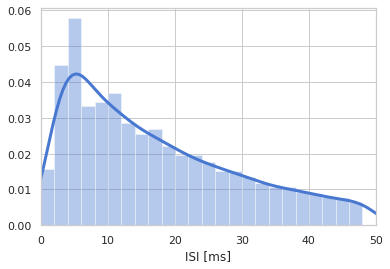

In [138]:
plot_isi_dist(unit_spk_train)

In [210]:
def get_waveforms(spk_train, hp_data, wf_lims = [-12,20], n_wf=5000):
    n_spikes = len(spk_train)
    n_chans = hp_data.shape[0]
    
    sampled_spikes = spk_train[np.random.randint(n_spikes,size=n_wf)]
    wf_samps = np.arange(wf_lims[0],wf_lims[1])
    
    mwf = np.zeros( (n_chans, len(wf_samps)) )
    for samp_spk in sampled_spikes:
        mwf += hp_data[:,wf_samps+samp_spk]
    mwf /= n_wf
    
    return mwf


In [213]:
wf = get_waveforms(unit_spk_train, spk_masked_signals.get_traces())

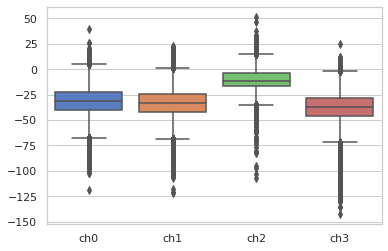

In [239]:
amps = pd.DataFrame(spk_masked_signals.get_traces()[:,unit_spk_train].T,columns=['ch'+str(ch) for ch in range(4)]) 
ax = sns.boxplot(data=amps)
#ax = sns.stripplot(data=amps, color='0.5',alpha=0.01,ax=ax)

array([-31.10394739, -33.29304889, -11.71070692, -37.17100282])

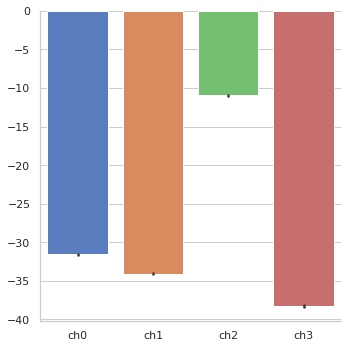

In [272]:
sns.catplot(data=amps,kind='bar')

In [254]:
mad(amps['ch0'])

9.038388818225485

In [198]:
n_spikes = len(unit_spk_train)
spk_samples = np.random.randint(n_spikes,size=1000)

In [199]:
spk_masked_signals.get_traces()[:,unit_spk_train[spk_samples]].mean(axis=1)

array([-30.84513251, -34.34057442, -10.58002391, -37.84151443])

In [193]:
spk_masked_signals.get_traces()[:,unit_spk_train].mean(axis=1)

array([-31.5363851 , -34.0596291 , -10.96521544, -38.2398363 ])

In [85]:
spkTrains = {}

for sorter_id, sort in sortDict.items():
    units = sort.get_unit_ids()
    if len(units)>0:
        for unit in units:
            key = sorter_id + '_' + str(unit)
            spkTrains[key] = sort.get_unit_spike_train(unit)


In [107]:
mc

{'MS4':    unit_ids  firing_rate        epoch_name  epoch_start  epoch_end
 0         1   437.768574  complete_session            0        inf
 1         2   509.480077  complete_session            0        inf
 2         3     1.574016  complete_session            0        inf
 3         4   340.698438  complete_session            0        inf,
 'KS2':     unit_ids  firing_rate        epoch_name  epoch_start  epoch_end
 0          0     4.390774  complete_session            0        inf
 1          1     2.636242  complete_session            0        inf
 2          2     1.619073  complete_session            0        inf
 3          3     5.852016  complete_session            0        inf
 4          4     8.925588  complete_session            0        inf
 5          5     5.481495  complete_session            0        inf
 6          6     4.814313  complete_session            0        inf
 7          7     5.342052  complete_session            0        inf
 8          8    13.5155

In [90]:
mc = {}
for sorter_id, sort  in sortDict.items():
    t0 = time.time()
    temp = st.validation.MetricCalculator(sort,spk_masked_signals)
    temp.compute_metrics (metric_names=['firing_rate'])
    mc[sorter_id] = temp.get_metrics_df()
    t1 = time.time()
    print('Time to compute metrics for {0} is {1:0.2f} :'.format(sorter_id,t1-t0))

Time to compute metrics for MS4 is 19.07 :
Time to compute metrics for KS2 is 18.13 :
Time to compute metrics for SC is 18.00 :


In [91]:
mc

{'MS4':    unit_ids  firing_rate        epoch_name  epoch_start  epoch_end
 0         1   437.768574  complete_session            0        inf
 1         2   509.480077  complete_session            0        inf
 2         3     1.574016  complete_session            0        inf
 3         4   340.698438  complete_session            0        inf,
 'KS2':     unit_ids  firing_rate        epoch_name  epoch_start  epoch_end
 0          0     4.390774  complete_session            0        inf
 1          1     2.636242  complete_session            0        inf
 2          2     1.619073  complete_session            0        inf
 3          3     5.852016  complete_session            0        inf
 4          4     8.925588  complete_session            0        inf
 5          5     5.481495  complete_session            0        inf
 6          6     4.814313  complete_session            0        inf
 7          7     5.342052  complete_session            0        inf
 8          8    13.5155

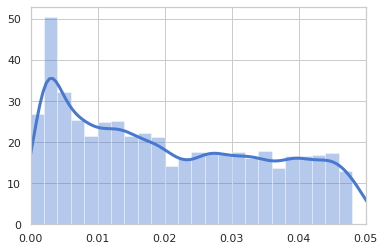

In [58]:
plot_isi_dist(spkTrains['KS2_8'])

In [172]:
keys = list(spkTrains.keys())
nKeys = len(keys)
    

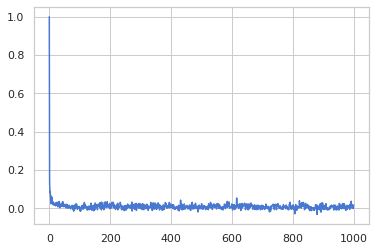

In [62]:
def acf(x, length=1000):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, length)])

plt.plot(acf(np.diff(spkTrains['KS2_8'])))

In [150]:
from spectrum import xcorr


/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/spectrum/datasets.py:23: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [-.2-.1j,.3+.2j,.5]], dtype=complex)


AssertionError: x and y must have the same length. Add zeros if needed

In [162]:
fs*0.01

32000

In [173]:
keys

['KS2_8', 'KS2_9', 'KS2_11', 'SC_2']

In [181]:

win = 20 # in ms
q = int(fs*win/1000)
x = np.zeros(nSamps)
x[spkTrains[keys[1]]] = 1
x2 = scipy.signal.decimate(x,q,ftype='fir')

y = np.zeros(nSamps)
y[spkTrains[keys[2]]] = 1
y2 = scipy.signal.decimate(y,q,ftype='fir')

In [ ]:
xc = np.correlate(x2,y2,mode='full')

In [ ]:
plt.plot(xc)

In [ ]:
c,l = xcorr(x2,y2,maxlags=100, norm='coeff')

In [109]:
# Mountainsort4 spike sorting
t0 = time.time()
default_ms4_params = ss.Mountainsort4Sorter.default_params()
default_ms4_params['detect_threshold'] = 4
default_ms4_params['curation'] = False
default_ms4_params['whiten'] = False

sorting_MS4 = ss.run_mountainsort4(recording=hp_masked_recording, **default_ms4_params, output_folder=str(storeDir / 'tmp_MS4'))
t1 = time.time()

print('Time to sort using MS4 = {0:0.2f}s'.format(t1-t0))
print('Units found with MS4:', sorting_MS4.get_unit_ids())

Time to sort using MS4 = 250.05s
Units found with MS4: [1, 2, 3, 4]


4

In [46]:
ms4_mc = st.validation.MetricCalculator(sorting_MS4,recording)
ms4_mc.compute_metrics()
print(ms4_mc.get_metrics_df())

/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/spikemetrics/utils.py:407: RuntimeWarning: invalid value encountered in true_divide
  spike_depths = np.sum(spike_feat_ind * pc_power, 1) / np.sum(pc_power, 1)
/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/spikemetrics/metrics.py:442: RuntimeWarning: All-NaN slice encountered
  max_drift[cluster_id] = np.around(np.nanmax(median_depths) - np.nanmin(median_depths), 2)


   unit_ids  num_spikes  firing_rate  presence_ratio  isi_viol  \
0         1   1413003.0   433.039171             1.0  0.352590   
1         2   1696068.0   519.789329             1.0  0.355747   
2         3      5139.0     1.574935             1.0  0.000000   
3         4   1096753.0   336.118897             1.0  0.352282   

   amplitude_cutoff        snr  max_drift  cumulative_drift  silhouette_score  \
0          0.018886   1.762746        NaN               0.0          0.015288   
1          0.185752   1.680599        NaN               0.0          0.008489   
2          0.002156  12.074905       0.96               0.0          0.641543   
3          0.001534   1.869403        NaN               0.0          0.008489   

   isolation_distance   l_ratio   d_prime  nn_hit_rate  nn_miss_rate  \
0           14.534889  0.234075  1.832169     0.504444      0.170741   
1           12.712829  0.268646  1.617707     0.444444      0.166296   
2           65.856281  0.000002  8.696275     0

In [47]:
# SpyKING Circus spike sorting
t0 = time.time()
SC_params = ss.SpykingcircusSorter.default_params()
SC_params['filter'] = False
SC_params['detect_threshold'] = 4

sorting_SC = ss.run_spykingcircus(recording=recording, **SC_params, output_folder=str(storeDir / 'tmp_SC'))
t1 = time.time()

print('Time to sort using SC = {0:0.2f}s'.format(t1-t0))
print('Units found with Spyking Circus:', sorting_SC.get_unit_ids())

RUNNING SHELL SCRIPT: /tmp/tmp_shellscripthj0ma_fh/script.sh
Time to sort using SC = 66.53s
Units found with Spyking Circus: [0, 1, 2, 3]


/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/spikeextractors/extractors/spykingcircusextractors/spykingcircusextractors.py:113: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_results = h5py.File(results)


In [48]:
SC_mc = st.validation.MetricCalculator(sorting_SC,recording)
SC_mc.compute_metrics()
print(SC_mc.get_metrics_df())

/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/spikemetrics/metrics.py:442: RuntimeWarning: All-NaN slice encountered
  max_drift[cluster_id] = np.around(np.nanmax(median_depths) - np.nanmin(median_depths), 2)


   unit_ids  num_spikes  firing_rate  presence_ratio  isi_viol  \
0         0     87002.0    26.663410             1.0  0.153979   
1         1    112784.0    34.564792             1.0  0.292669   
2         2     73783.0    22.612197             1.0  0.326648   
3         3     84172.0    25.796103             1.0  0.207490   

   amplitude_cutoff       snr  max_drift  cumulative_drift  silhouette_score  \
0          0.000580  3.158155       0.00               0.0          0.024857   
1          0.000078  3.835446       0.28               0.0          0.066319   
2          0.024701  3.390523        NaN               0.0          0.230705   
3          0.000089  3.496941       0.00               0.0          0.024857   

   isolation_distance   l_ratio   d_prime  nn_hit_rate  nn_miss_rate  \
0           11.716670  0.306610  1.417384     0.485556      0.183704   
1           14.429958  0.235511  1.931091     0.594444      0.139630   
2           23.021330  0.056707  4.068965     0.9233

In [49]:
# Kilosort2 spike sorting (KILOSORT2_PATH and NPY_MATLAB_PATH can be set as environment variables)
#import os
#os.environ["KILOSORT2_PATH"] = "/home/alexgonzalez/Documents/MATLAB/Kilosort2/"
#os.environ["NPY_MATLAB_PATH"] = "/home/alexgonzalez/Documents/MATLAB/npy-matlab/"
t0 = time.time()
ks_params =  ss.Kilosort2Sorter.default_params()
ks_params['detect_threshold'] = 4
ks_params['car'] = False

ss.Kilosort2Sorter.set_kilosort2_path('/home/alexgonzalez/Documents/MATLAB/Kilosort2/')
sorting_KS2 = ss.run_kilosort2(recording, **ks_params, output_folder= str(storeDir / 'tmp_KS2'))
t1 = time.time()
print('Time to sort using KS2 = {0:0.2f}s'.format(t1-t0))
print('Units found with Kilosort2', sorting_KS2.get_unit_ids())


Setting KILOSORT2_PATH environment variable for subprocess calls to: /home/alexgonzalez/Documents/MATLAB/Kilosort2/
RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptl1kf8mcq/script.sh
Time to sort using KS2 = 102.32s
Units found with Kilosort2 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


In [39]:
# Tridesclous spike sorting
ss = reload(ss)
TDC_params =  ss.TridesclousSorter.default_params()
TDC_params['relative_threshold'] = 4

shutil.rmtree(str(storeDir / 'tmp_TDC'),ignore_errors=True,onerror=None)

to = time.time()
sorting_TDC = ss.run_tridesclous(recording, **TDC_params,output_folder=str(storeDir / 'tmp_TDC'))
t1 = time.time()
print('Time to sort using TDC = {0:0.2f}s'.format(t1-t0))
print('Units found with Tridesclous:', sorting_TDC.get_unit_ids())


Time to sort using TDC = 376.79s
Units found with Tridesclous: []


In [50]:
# herding spikes
t0 = time.time()
sorting_HS = ss.run_herdingspikes(recording,output_folder=str(storeDir / 'tmp_HS'))
t1 = time.time()
print('Time to sort using HerdingSpikes = {0:0.2f}s'.format(t1-t0))
print('Units found with HerdingSpikes:', sorting_HS.get_unit_ids())


# Generating new position and neighbor files from data file
# Not Masking any Channels
# Sampling rate: 32000
# Localization On
# Number of recorded channels: 4
# Analysing frames: 104415744; Seconds: 3262.992
# Frames before spike in cutout: 6
# Frames after spike in cutout: 51
# tcuts: 51 96
# tInc: 100000
# Analysing frames from -51 to 100096  (0.0%)
# Analysing frames from 99949 to 200096  (0.1%)
# Analysing frames from 199949 to 300096  (0.2%)
# Analysing frames from 299949 to 400096  (0.3%)
# Analysing frames from 399949 to 500096  (0.4%)
# Analysing frames from 499949 to 600096  (0.5%)
# Analysing frames from 599949 to 700096  (0.6%)
# Analysing frames from 699949 to 800096  (0.7%)
# Analysing frames from 799949 to 900096  (0.8%)
# Analysing frames from 899949 to 1000096  (0.9%)
# Analysing frames from 999949 to 1100096  (1.0%)
# Analysing frames from 1099949 to 1200096  (1.1%)
# Analysing frames from 1199949 to 1300096  (1.1%)
# Analysing frames from 1299949 to 1400096  (1.2%)


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    1.6s remaining:    9.0s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    1.7s remaining:    0.7s


Number of estimated units: 7
Saving to /Data_SSD2T/Data/PreProcessed/Li/Li_T3g_062518/tt_8/tmp_HS/HS2_sorted.hdf5


[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    1.9s finished


OSError: Unable to create file (unable to truncate a file which is already open)

In [41]:
HS_mc = st.validation.MetricCalculator(sorting_HS,recording)
HS_mc.compute_metrics()
print(HS_mc.get_metrics_df())

/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/spikemetrics/utils.py:407: RuntimeWarning: invalid value encountered in true_divide
  spike_depths = np.sum(spike_feat_ind * pc_power, 1) / np.sum(pc_power, 1)
/home/alexgonzalez/anaconda3/envs/spk/lib/python3.7/site-packages/spikemetrics/metrics.py:442: RuntimeWarning: All-NaN slice encountered
  max_drift[cluster_id] = np.around(np.nanmax(median_depths) - np.nanmin(median_depths), 2)


   unit_ids  num_spikes  firing_rate  presence_ratio    isi_viol  \
0         0     15434.0     4.730114            1.00    0.025670   
1         1      4972.0     1.523787            1.00    0.049492   
2         2      3017.0     0.924631            0.99    0.000000   
3         3      2965.0     0.908694            1.00    0.139114   
4         4      1604.0     0.491584            0.99    0.475349   
5         5       147.0     0.045052            0.72    0.000000   
6         6        59.0     0.018082            0.39  351.331429   
7         7       195.0     0.059762            0.61    0.000000   

   amplitude_cutoff        snr  max_drift  cumulative_drift  silhouette_score  \
0          0.003032   9.492501       3.01              0.00          0.304406   
1          0.012831  12.018629       0.65              0.86          0.326005   
2          0.000086   8.024553       2.38              0.00          0.126969   
3          0.000087   7.366896       1.21              0.00    

In [42]:
# Klusta
t0 = time.time()
#klusta_params = ss.KlustaSorter.default_params()
sorting_klusta = ss.run_klusta(recording,output_folder=str(storeDir / 'tmp_klusta'))
t1 = time.time()
print('Time to sort using Klusta = {0:0.2f}s'.format(t1-t0))
print('Units found with Klusta:', sorting_klusta.get_unit_ids())

resting

RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptfxowmomv/script.sh


Exception: klusta returned a non-zero exit code

{'adjacency_radius': None,
 'threshold_strong_std_factor': 5,
 'threshold_weak_std_factor': 2,
 'detect_sign': -1,
 'extract_s_before': 16,
 'extract_s_after': 32,
 'n_features_per_channel': 3,
 'pca_n_waveforms_max': 10000,
 'num_starting_clusters': 50}

In [101]:
# compare SC KS MS4
import spikecomparison as sc
import spikewidgets as sw
mcmp = sc.compare_multiple_sorters(sorting_list=[sorting_KS2,sorting_MS4,sorting_SC,sorting_hs],name_list=['KS2','MS4','SC','HS'],verbose=True)

Multicomaprison step1: pairwise comparison
  Comparing:  KS2  and  MS4
  Comparing:  KS2  and  SC
  Comparing:  KS2  and  HS
  Comparing:  MS4  and  SC
  Comparing:  MS4  and  HS
  Comparing:  SC  and  HS
Multicomaprison step2: make graph
Multicomaprison step3: extract agreement from graph
multicomaprison step4 : make agreement spiketrains


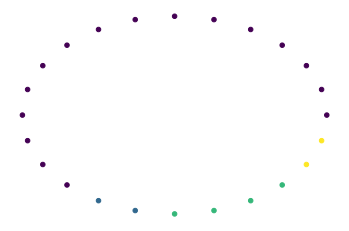

In [84]:
sw.plot_multicomp_graph(mcmp)

In [102]:
agr_2 = mcmp.get_agreement_sorting(minimum_matching=2)

In [104]:
agr_2.get_unit_ids()

[]

In [99]:
comp1 = sc.compare_two_sorters(sorting1=sorting_KS2,sorting2=sorting_MS4,sorting1_name='KS2',sorting2_name='MS4')
comp2 = sc.compare_two_sorters(sorting1=sorting_SC,sorting2=sorting_hs,sorting1_name='SC',sorting2_name='HS')
comp3 = sc.compare_two_sorters(sorting1=sorting_SC,sorting2=sorting_MS4,sorting1_name='SC',sorting2_name='MS4')
comp4 = sc.compare_two_sorters(sorting1=sorting_HS,sorting2=sorting_MS4,sorting1_name='HS',sorting2_name='MS4')


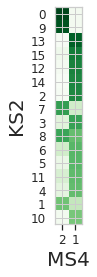

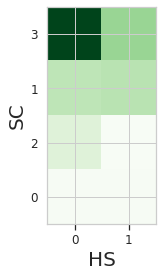

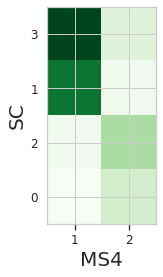

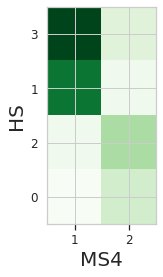

In [100]:
sw.plot_agreement_matrix(comp1)
sw.plot_agreement_matrix(comp2)

sw.plot_agreement_matrix(comp3)

sw.plot_agreement_matrix(comp4)

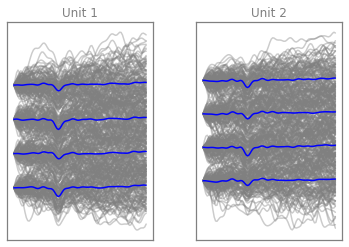

In [119]:
w_wf = sw.plot_unit_waveforms(recording, sorting_MS4, max_spikes_per_unit=100)

In [108]:
int(np.max([0.1*recording.get_num_frames()/recording.get_sampling_frequency(),180]))

326

In [31]:
180/190

0.9473684210526315